In [ ]:
import yfinance as yf 
import pandas as pd
import numpy as np


In [ ]:
from datetime import datetime
late_year = 10
end = datetime.now()
start = datetime(end.year - late_year, end.month, end.day)

In [ ]:
symbol = ['AAPL']
df = yf.download(symbol, start=start, end=end)

In [ ]:
df

In [ ]:
df.columns = df.columns.droplevel('Ticker')
df.reset_index(inplace=True)

In [ ]:
df['SMA100'] = df['Close'].rolling(window=100).mean()
df['SMA50'] = df['Close'].rolling(window=50).mean()

In [ ]:
df['SMA20'] = df['Close'].rolling(window=20).mean()
df['SMA7'] = df['Close'].rolling(window=7).mean()
df['SMA21'] = df['Close'].rolling(window=21).mean()

In [ ]:
df

In [ ]:
df= df[251:]

In [ ]:
df

In [ ]:
df.to_csv('AAPL.csv')

In [ ]:
df['Trend'] = np.where(df['SMA7'] > df['SMA21'], 1, 0)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
features = ['Close', 'SMA7', 'SMA21']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])



In [ ]:
sequence_length = 30

X, y_trend, y_price = [], [], []

In [ ]:
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y_trend.append(df['Trend'].iloc[i])
    y_price.append(scaled_data[i, 0])

In [ ]:
X, y_trend, y_price = np.array(X), np.array(y_trend), np.array(y_price)

In [ ]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_trend_train, y_trend_test = y_trend[:split], y_trend[split:]
y_price_train, y_price_test = y_price[:split], y_price[split:]

[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open    Volume
Ticker           GOOG       GOOG       GOOG       GOOG      GOOG
Date                                                            
2020-01-02  68.123726  68.162086  66.837348  66.837348  28132000
2020-01-03  67.789421  68.379304  67.036329  67.151713  23728000
2020-01-06  69.460922  69.575007  67.258334  67.258334  34646000
2020-01-07  69.417580  69.898350  69.270107  69.646760  30054000
2020-01-08  69.964615  70.326314  69.293024  69.354799  30560000
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.8024 - price_output_loss: 0.1116 - price_output_mse: 0.1117 - trend_output_accuracy: 0.5534 - trend_output_loss: 0.6908 - val_loss: 0.6553 - val_price_output_loss: 0.0036 - val_price_output_mse: 0.0036 - val_trend_output_accuracy: 0.7875 - val_trend_output_loss: 0.6456
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6942 - price_output_loss: 0.0086 - price_output_mse: 0.0086 - trend_output_accuracy: 0.5

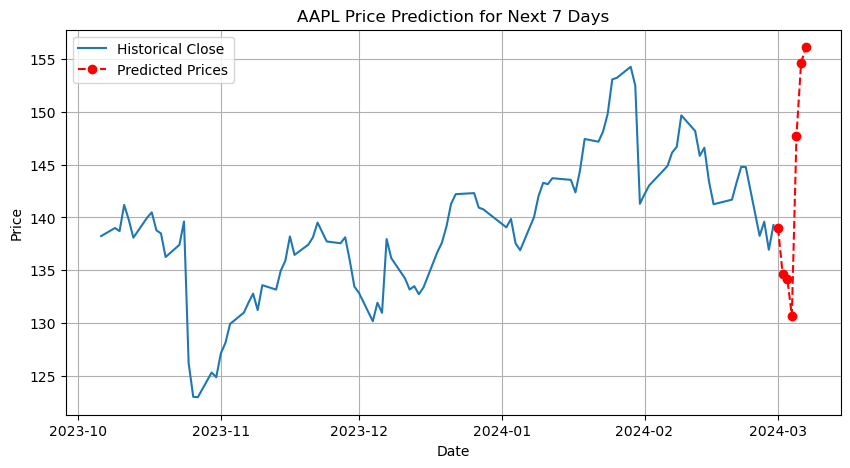

In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Step 1: Download data from Yahoo Finance
df = yf.download('goog', start='2020-01-01', end='2024-03-01')
print(df.head())
# Step 2: Calculate SMA7 and SMA21
df['SMA7'] = df['Close'].rolling(window=7).mean()
df['SMA21'] = df['Close'].rolling(window=21).mean()

# Drop NaN values
df.dropna(inplace=True)

# Step 3: Create target variable for crossover (1 if SMA7 > SMA21 else 0)
df['Trend'] = np.where(df['SMA7'] > df['SMA21'], 1, 0)

# Step 4: Prepare data for LSTM
features = ['Close', 'SMA7', 'SMA21']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

# Define sequence length
sequence_length = 30

X, y_trend, y_price = [], [], []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y_trend.append(df['Trend'].iloc[i])
    y_price.append(scaled_data[i, 0])  # Close price

X, y_trend, y_price = np.array(X), np.array(y_trend), np.array(y_price)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_trend_train, y_trend_test = y_trend[:split], y_trend[split:]
y_price_train, y_price_test = y_price[:split], y_price[split:]
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
# Step 5: Build LSTM Model using Functional API
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = LSTM(64, return_sequences=True)(input_layer)
x = LSTM(32)(x)
x = Dense(16, activation='relu')(x)

# Two outputs
trend_output = Dense(1, activation='sigmoid', name='trend_output')(x)
price_output = Dense(1, activation='linear', name='price_output')(x)

model = Model(inputs=input_layer, outputs=[trend_output, price_output])

model.compile(loss={'trend_output':'binary_crossentropy', 'price_output':'mse'},
              optimizer='adam',
              metrics={'trend_output':'accuracy', 'price_output':'mse'})

# Step 6: Train the model
history = model.fit(X_train, {'trend_output': y_trend_train, 'price_output': y_price_train},
                    epochs=50, batch_size=32, validation_split=0.1)

# Step 7: Predict next 7 days
last_sequence = scaled_data[-sequence_length:]
predictions_trend = []
predictions_price = []

current_sequence = last_sequence.reshape(1, sequence_length, len(features))

for _ in range(7):
    pred_trend, pred_price = model.predict(current_sequence, verbose=0)
    predictions_trend.append(int(pred_trend[0][0] > 0.5))
    predictions_price.append(pred_price[0][0])

    new_close = pred_price[0][0]
    new_row = np.array([new_close, 0, 0])
    current_sequence = np.append(current_sequence[:, 1:, :], [[new_row]], axis=1)

predicted_prices = scaler.inverse_transform(
    np.column_stack((predictions_price, np.zeros((7, 2))))
)[:, 0]

# Step 8: Display predictions
for i, (trend, price) in enumerate(zip(predictions_trend, predicted_prices), 1):
    trend_str = 'Uptrend' if trend == 1 else 'Downtrend'
    print(f"Day {i}: Predicted Price = ${price:.2f}, Trend = {trend_str}")

# Optional: Plot predictions
plt.figure(figsize=(10, 5))
plt.plot(df.index[-100:], df['Close'][-100:], label='Historical Close')
future_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=7)
plt.plot(future_dates, predicted_prices, marker='o', linestyle='--', color='red', label='Predicted Prices')
plt.title('AAPL Price Prediction for Next 7 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [5]:
model.save('lstm_model.h5')
print("Model saved as 'lstm_model.h5'")

Model saved as 'lstm_model.h5'


In [6]:
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import load_model
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set page configuration
st.set_page_config(
    page_title="Stock Price Predictor",
    page_icon="📈",
    layout="wide"
)

# Add title and description
st.title("Stock Price Visualization and Prediction")
st.markdown("Select a stock symbol and date range to visualize historical data and see price predictions using an LSTM model.")

# Create sidebar for inputs
st.sidebar.header("Input Parameters")

# Stock symbol selection
symbol = st.sidebar.text_input("Enter Stock Symbol (e.g., AAPL, MSFT, GOOGL)", "AAPL")

# Date range selection
today = datetime.now().date()
one_year_ago = today - timedelta(days=365)

start_date = st.sidebar.date_input("Start Date", one_year_ago)
end_date = st.sidebar.date_input("End Date", today)

# Function to load and preprocess data
@st.cache_data
def load_data(symbol, start_date, end_date):
    try:
        # Download the data
        df = yf.download(symbol, start=start_date, end=end_date)

        if df.empty:
            st.error(f"No data found for {symbol}. Please check the stock symbol and try again.")
            return None

        # Add some technical indicators
        # Moving averages
        df['MA5'] = df['Close'].rolling(window=5).mean()
        df['MA20'] = df['Close'].rolling(window=20).mean()
        df['MA50'] = df['Close'].rolling(window=50).mean()

        # Volume moving average
        df['Volume_MA10'] = df['Volume'].rolling(window=10).mean()

        return df
    except Exception as e:
        st.error(f"Error loading data: {e}")
        return None

# Function to prepare data for LSTM
def prepare_lstm_data(df, look_back=60):
    # Extract only the Close price
    data = df['Close'].values.reshape(-1, 1)

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Create sequences for prediction (last look_back days)
    x_test = []
    if len(scaled_data) > look_back:
        x_test.append(scaled_data[-look_back:, 0])
    else:
        # Handle case when not enough data is available
        padding = np.zeros(look_back - len(scaled_data))
        x_test.append(np.concatenate((padding, scaled_data[:, 0])))

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return x_test, scaler, data

# Function to make predictions
def predict_future(model, x_test, scaler, forecast_days=30):
    # Make a copy of the last sequence
    curr_seq = x_test[0].copy()
    future_predictions = []

    # Predict next 'forecast_days' values
    for _ in range(forecast_days):
        # Get prediction for the next day (scaled)
        pred = model.predict(curr_seq.reshape(1, curr_seq.shape[0], 1), verbose=0)

        # Add the prediction to our list
        future_predictions.append(pred[0, 0])

        # Update the sequence by removing the first element and adding the new prediction
        curr_seq = np.append(curr_seq[1:], pred[0, 0])

    # Rescale predictions back to original scale
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    future_predictions = scaler.inverse_transform(future_predictions)

    return future_predictions

# Main execution
if st.sidebar.button("Load Data and Predict"):
    with st.spinner('Loading data and generating predictions...'):
        # Load stock data
        df = load_data(symbol, start_date, end_date)

        if df is not None:
            try:
                # Create two columns for the layout
                col1, col2 = st.columns(2)

                # Display basic info in the first column
                with col1:
                    st.subheader(f"Stock Information: {symbol}")
                    st.write("Data Range:", start_date, "to", end_date)
                    st.write("Latest Close Price: $", round(df['Close'].iloc[-1], 2))

                    # Calculate some stats
                    price_change = df['Close'].iloc[-1] - df['Close'].iloc[0]
                    price_change_percent = (price_change / df['Close'].iloc[0]) * 100

                    if price_change >= 0:
                        st.write("Overall Change: ",
                                f"📈 +${round(price_change, 2)} (+{round(price_change_percent, 2)}%)")
                    else:
                        st.write("Overall Change: ",
                                f"📉 -${round(abs(price_change), 2)} ({round(price_change_percent, 2)}%)")

                # Show recent data in the second column
                with col2:
                    st.subheader("Recent Stock Data")
                    st.dataframe(df.tail().style.format({"Open": "${:.2f}",
                                                         "High": "${:.2f}",
                                                         "Low": "${:.2f}",
                                                         "Close": "${:.2f}",
                                                         "Adj Close": "${:.2f}",
                                                         "MA5": "${:.2f}",
                                                         "MA20": "${:.2f}",
                                                         "MA50": "${:.2f}"}))

                # Create interactive plot with Plotly
                st.subheader("Historical Price and Volume")

                fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                                    vertical_spacing=0.1,
                                    subplot_titles=('Price', 'Volume'),
                                    row_heights=[0.7, 0.3])

                # Add price candlestick
                fig.add_trace(
                    go.Candlestick(
                        x=df.index,
                        open=df['Open'],
                        high=df['High'],
                        low=df['Low'],
                        close=df['Close'],
                        name="OHLC"
                    ),
                    row=1, col=1
                )

                # Add moving averages
                fig.add_trace(
                    go.Scatter(
                        x=df.index,
                        y=df['MA5'],
                        name="MA5",
                        line=dict(color='purple', width=1)
                    ),
                    row=1, col=1
                )

                fig.add_trace(
                    go.Scatter(
                        x=df.index,
                        y=df['MA20'],
                        name="MA20",
                        line=dict(color='orange', width=1)
                    ),
                    row=1, col=1
                )

                fig.add_trace(
                    go.Scatter(
                        x=df.index,
                        y=df['MA50'],
                        name="MA50",
                        line=dict(color='green', width=1)
                    ),
                    row=1, col=1
                )

                # Add volume bars
                colors = ['red' if row['Open'] - row['Close'] >= 0
                          else 'green' for i, row in df.iterrows()]

                fig.add_trace(
                    go.Bar(
                        x=df.index,
                        y=df['Volume'],
                        marker_color=colors,
                        name="Volume"
                    ),
                    row=2, col=1
                )

                # Add volume moving average
                fig.add_trace(
                    go.Scatter(
                        x=df.index,
                        y=df['Volume_MA10'],
                        name="Volume MA10",
                        line=dict(color='black', width=1)
                    ),
                    row=2, col=1
                )

                # Update layout
                fig.update_layout(
                    title=f"{symbol} Stock Price and Volume",
                    xaxis_title="Date",
                    yaxis_title="Price ($)",
                    height=600,
                    legend=dict(
                        orientation="h",
                        yanchor="bottom",
                        y=1.02,
                        xanchor="right",
                        x=1
                    ),
                    xaxis_rangeslider_visible=False
                )

                st.plotly_chart(fig, use_container_width=True)

                # Load the LSTM model
                try:
                    # Try to load model
                    st.info("Loading LSTM model...")
                    model = load_model('lstm_model.h5')

                    # Prepare data for prediction
                    x_test, scaler, original_data = prepare_lstm_data(df)

                    # Make future predictions
                    forecast_days = 30  # Predict for the next 30 days
                    future_pred = predict_future(model, x_test, scaler, forecast_days)

                    # Create date range for the prediction
                    last_date = df.index[-1]
                    prediction_dates = pd.date_range(start=last_date + timedelta(days=1),
                                                    periods=forecast_days)

                    # Create a dataframe for predictions
                    forecast_df = pd.DataFrame({
                        'Predicted_Close': future_pred.flatten()
                    }, index=prediction_dates)

                    # Plot the historical and predicted prices
                    st.subheader(f"LSTM Model Prediction for {symbol} (Next {forecast_days} Days)")

                    fig = go.Figure()

                    # Add historical data
                    fig.add_trace(
                        go.Scatter(
                            x=df.index,
                            y=df['Close'],
                            mode='lines',
                            name='Historical Close Price',
                            line=dict(color='blue')
                        )
                    )

                    # Add predicted data
                    fig.add_trace(
                        go.Scatter(
                            x=forecast_df.index,
                            y=forecast_df['Predicted_Close'],
                            mode='lines',
                            name='Predicted Close Price',
                            line=dict(color='red', dash='dash')
                        )
                    )

                    # Add a vertical line to separate historical from prediction
                    fig.add_vline(x=last_date, line_width=1, line_dash="dash", line_color="black")

                    # Update layout
                    fig.update_layout(
                        title=f"{symbol} Stock Price Prediction",
                        xaxis_title="Date",
                        yaxis_title="Price ($)",
                        height=500,
                        legend=dict(
                            orientation="h",
                            yanchor="bottom",
                            y=1.02,
                            xanchor="right",
                            x=1
                        )
                    )

                    st.plotly_chart(fig, use_container_width=True)

                    # Display prediction data
                    st.subheader("Prediction Data")
                    st.dataframe(forecast_df.style.format({"Predicted_Close": "${:.2f}"}))

                    # Calculate predicted returns
                    current_price = df['Close'].iloc[-1]
                    future_price = forecast_df['Predicted_Close'].iloc[-1]
                    predicted_change = future_price - current_price
                    predicted_percent = (predicted_change / current_price) * 100

                    st.subheader("Prediction Summary")
                    col1, col2, col3 = st.columns(3)
                    with col1:
                        st.metric("Current Price", f"${current_price:.2f}")
                    with col2:
                        st.metric(f"Predicted Price ({forecast_days} days)", f"${future_price:.2f}")
                    with col3:
                        st.metric("Predicted Change",
                                f"{predicted_change:.2f} ({predicted_percent:.2f}%)",
                                delta=f"{predicted_percent:.2f}%")

                except Exception as e:
                    st.error(f"Error loading or using the LSTM model: {e}")
                    st.warning("Make sure the 'lstm_model.h5' file exists and is compatible with your TensorFlow version.")

                    # Display a message about model training
                    st.info("""
                    Note: To use this application properly, you need to have a trained LSTM model saved as 'lstm_model.h5'.

                    If you don't have a model yet, you would typically:
                    1. Train an LSTM model on historical stock data
                    2. Save the model using `model.save('lstm_model.h5')`
                    3. Place the model file in the same directory as this script
                    """)

            except Exception as e:
                st.error(f"An error occurred: {e}")

# Add information about the app
st.sidebar.markdown("---")
st.sidebar.subheader("About")
st.sidebar.info("""
This app visualizes stock data and provides predictions using a pre-trained LSTM model.
- Data is fetched from Yahoo Finance using the yfinance library
- Predictions are made using a deep learning LSTM model
- The model must be saved as 'lstm_model.h5' in the same directory as this app
""")

# Add a warning about predictions
st.sidebar.warning("""
⚠️ Disclaimer: Stock price predictions are for educational purposes only and should not be used for financial decisions.
""")

2025-03-02 23:51:40.760 
  command:

    streamlit run /home/sourabh/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-03-02 23:51:40.761 Session state does not function when running a script without `streamlit run`
2025-03-02 23:51:40.762 No runtime found, using MemoryCacheStorageManager


DeltaGenerator(_root_container=1, _parent=DeltaGenerator())